# Sample Notebook

This notebook is to demonstrate denoising sampling with our model.

In [37]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import torch
from diffusers import AutoencoderKL
from fillerbuster.data.datasets.fillerbuster_data import FillerbusterData
from fillerbuster.data.datasets.dl3dv_dataset import DL3DVDataset
import mediapy
from fillerbuster.utils.visualization_utils import multi_view_batch_to_image, draw_multi_view_batch, get_summary_image_list, get_masked_image, draw_cameras
from fillerbuster.utils.random_utils import seed_worker
from fillerbuster.pipelines.nerfstudio_inpaint_pipeline import random_train_pose
from fillerbuster.pipelines.pipeline_functions import (
    get_cameras,
    denoise_sample,
    encode_image,
    decode_image,
)
from fillerbuster.pipelines.base_pipeline import get_pipeline
import viser
from fillerbuster.data.datasets.dataset_transforms import augment_origins_and_direction
from fillerbuster.utils.camera_path_utils import interpolate_between_cameras, fit_cameras
import time
from dataclasses import dataclass
from fillerbuster.configs.base import DGXCheckpointsConfig
import logging
import numpy as np
from nerfstudio.configs.method_configs import method_configs
from fillerbuster.pipelines.nerfstudio_inpaint_pipeline import InpaintPipelineConfig
import copy
from pathlib import Path
import random
from nerfstudio.cameras.cameras import Cameras

shutterstock3d_folder = "/mnt/captures/spaces/datasets/shutterstock_3d"
scannetpp_folder = "/mnt/captures/spaces/datasets/scannetpp_v1"
dl3dv_folder = "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/"
mvimgnet_folder = "/mnt/captures/spaces/datasets/mvimgnet/"

seed = 1
local_rank = 0
mixed_precision = True
viser_port = 8890
device = "cuda:0"
data = "/mnt/home/ethanjohnweber/data/nerfbusters-dataset/picnic"

if "viser_server" not in globals():
    # only run this once per Python process start
    viser_server = viser.ViserServer(port=viser_port)

print(f"Using GPU name: {torch.cuda.get_device_name(0)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU name: NVIDIA A100-SXM4-80GB


# Load Inpainting Pipeline

In [38]:
fillerbuster_config = copy.deepcopy(method_configs["splatfacto"])
del fillerbuster_config.pipeline.__dict__["_target"]
nerfstudio_pipeline_config = InpaintPipelineConfig(**fillerbuster_config.pipeline.__dict__)
nerfstudio_pipeline_config.datamanager.data = Path(data)
if "nerfbusters-dataset" in data:
    nerfstudio_pipeline_config.datamanager.dataparser.eval_mode = "filename"
nerfstudio_pipeline = nerfstudio_pipeline_config.setup(device=device)
inpainter = nerfstudio_pipeline.inpainter

[14:33:24] Auto image downscale factor of 1                                                 ]8;id=517246;file:///home/ethanjohnweber/rsc/fillerbuster/fillerbuster/external/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=99392;file:///home/ethanjohnweber/rsc/fillerbuster/fillerbuster/external/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#495\495]8;;\

Loading fillerbuster inpainter...


Text encoder loaded!

Loading the image vae from the checkpoint: /home/ethanjohnweber/data/checkpoints/dgx-checkpoints/image-vae.ckpt
Loading the image vae weights done.
Loading the pose vae from the checkpoint: /home/ethanjohnweber/data/checkpoints/dgx-checkpoints/pose-vae.ckpt
Loading the pose vae weights done.
Resuming the training from the checkpoint: /home/ethanjohnweber/data/checkpoints/dgx-checkpoints/transformer.ckpt
Loading the transformer weights done.
Done loading inpainter.


[14:33:38] Caching / undistorting train images                                            ]8;id=663274;file:///home/ethanjohnweber/rsc/fillerbuster/fillerbuster/external/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=99708;file:///home/ethanjohnweber/rsc/fillerbuster/fillerbuster/external/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#230\230]8;;\

Output()

# Load Data

In [39]:
patch_size = 256
num_patches = 16
batch_size = 1
data_type = "nerfstudio" # "train" or "eval" or "nerfstudio"
eval_stride = -1
train_mprobs = (0.2, 0.0, 0.4, 0.4)
percent_force_one_patch_per_image = 1.0
percent_force_fixed_location = 0.0
percent_force_center_crop = 1.0

In [40]:
if data_type == "train":
    dataloader = FillerbusterData(
        local_rank=local_rank,
        global_rank=0,
        world_size=1,
        seed=seed,
        shuffle=True,
        num_patches=num_patches,
        patch_size=patch_size,
        mview_batch_size=batch_size,
        num_workers=0,
        ms_dataset_ratio=(1, 0),
        mprobs=train_mprobs,
        use_gpu=True,
        shutterstock3d_folder=shutterstock3d_folder,
        scannetpp_folder=scannetpp_folder,
        dl3dv_folder=dl3dv_folder,
        mvimgnet_folder=mvimgnet_folder,
        use_ray_augmentation=True,
        percent_force_one_patch_per_image=percent_force_one_patch_per_image,
        percent_force_fixed_location=percent_force_fixed_location,
        percent_force_center_crop=percent_force_center_crop,
    )
elif data_type == "eval":
    dataset = DL3DVDataset(
        local_rank=local_rank,
        global_rank=0,
        world_size=1,
        seed=seed,
        folder=dl3dv_folder,
        subfolders=("7K",),
        shuffle=False,
        num_patches=num_patches,
        strides = (eval_stride,),
        patch_size=patch_size,
        # camera_res_scale_factor=1.0 * patch_size / 256,
        camera_res_scale_factor=0.5 * patch_size / 256,
        use_gpu=False,
        use_ray_augmentation=True,
        percent_force_one_patch_per_image=percent_force_one_patch_per_image,
        percent_force_fixed_location=percent_force_fixed_location,
        percent_force_center_crop=percent_force_center_crop,
    )
    def get_dataloader():
        # wrapping the dataloader in a function to get repeatable sampling
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            worker_init_fn=seed_worker,
            pin_memory=False,
        )
    dataloader = get_dataloader()
elif data_type == "nerfstudio":
    from fillerbuster.data.datasets.nerfstudio_dataset import NerfstudioDataset
    # folder = "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/0bd9de0e3be5536ba4a2537022cb21d41febe9c7fafb1a6c81d40fc8020ec5c2"
    # scale = 0.5
    # folder = "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/06a9deced111c7dfabdd38955de3844b3401477e9df0f81c0a706753c1b180a0"
    # scale = 0.5
    # folder = "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/2bf5b1f8adf18b293afd168666b56ef47fbf5ebd8358f8cd5bdce60bb44a50aa"
    # scale = 0.5
    # folder = "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/20bea6d42aa3f8ed4d66d84a3bfa18d39254398f4bd272931069fb07c39ffb8f"
    # "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/728b982198184601106e55de74236338ceb95471502ca464f915d2a8cb06f215"
    # "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/961ccff1914ea1b41c65c47a88dc500d62c50b5732519003392e36b7b557d870"
    # "/mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/7db9c2c373e9ccd37ac34c66d8a4bdf6274b5600e15731f83e8950d7a120cff4"
    folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/waldo_kitchen" # kitchen
    # folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/book_store"
    # folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/sunnyside"
    # folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/teatime"
    # folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/bouquet"
    # folder = "/mnt/home/ethanjohnweber/data/lerf-dataset/donuts"
    dataset = NerfstudioDataset(
        local_rank=local_rank,
        global_rank=0,
        world_size=1,
        seed=seed,
        # folder="/mnt/captures/spaces/datasets/nerfstudio-dataset",
        # folder="/mnt/home/ethanjohnweber/data/nerfbusters-dataset",
        folder=folder,
        shuffle=False,
        num_patches=num_patches,
        strides = (eval_stride,),
        patch_size=patch_size,
        # camera_res_scale_factor=0.7 * patch_size / 512,
        camera_res_scale_factor=0.7 * patch_size / 512,
        use_gpu=False,
        use_ray_augmentation=True,
        percent_force_one_patch_per_image=percent_force_one_patch_per_image,
        percent_force_fixed_location=percent_force_fixed_location,
        percent_force_center_crop=percent_force_center_crop,
        downscale_factor=1.0,
    )
    def get_dataloader():
        # wrapping the dataloader in a function to get repeatable sampling
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            worker_init_fn=seed_worker,
            pin_memory=False,
        )
    dataloader = get_dataloader()
else:
    raise ValueError(f"data_type {data_type} is not implemented!")

In [41]:
# blue-swings /mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7fK/4f8407138a4507bae7d0e3bb7324d2b394f5f822297e3a97923232629ee1d793
# benches /mnt/captures/spaces/datasets/DL3DV-10K/DL3DV-ALL-960P/7K/99936e36a6ef86d54d5464faaff472ed92f504c304a7e466389e3e06c8007e83


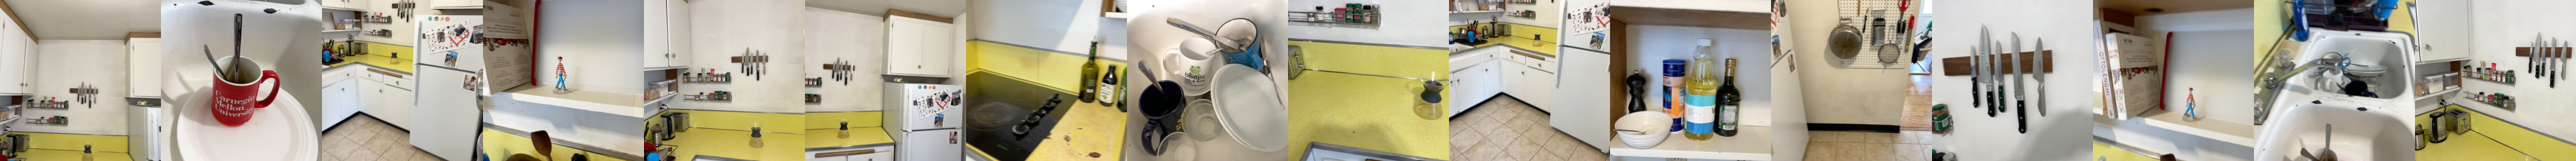

In [21]:
# fetch data and move to GPU
for i, batch in enumerate(dataloader):
    if i == 0:
        break
mediapy.show_image(multi_view_batch_to_image(batch["image"]))

In [22]:
dataset_name = "hellotemp"
NUMBER_FOR_COND = 4
flexible_folder = Path(f"/mnt/home/ethanjohnweber/data/assets/flexible/{dataset_name}/{NUMBER_FOR_COND}")
# flexible_folder_images = Path(f"/mnt/home/ethanjohnweber/data/assets/flexible/{dataset_name}/images")
# flexible_folder_screenshots = Path(f"/mnt/home/ethanjohnweber/data/assets/flexible/{dataset_name}/screenshots")
# flexible_folder_videos = Path(f"/mnt/home/ethanjohnweber/data/assets/flexible/{dataset_name}/videos")
# make these folders
flexible_folder.mkdir(parents=True, exist_ok=True)
# flexible_folder_images.mkdir(parents=True, exist_ok=True)
# flexible_folder_screenshots.mkdir(parents=True, exist_ok=True)
# flexible_folder_videos.mkdir(parents=True, exist_ok=True)

# Multi-View Inpainting

In [23]:
num_test_timesteps = 50
cfg_mv = 5.0
cfg_mv_known = 1.1
cfg_te = 0.0
text = ""
uncond_text = ""
image_strength = 1.0
show_summary = True
show_flattened_video = False # for saving the whole batch as one asset
summary_video_seconds = 8
summary_video_show_top_only = True
summary_image_height = None
summary_video_start_index = 0
rotation_num = 16
concat_start = False
predict_camera_poses = False
interpolation_steps = 0 # 8
orient_cameras = True
add_circle_views = False
# known_image = (0, 7, 8, 15, 16, -1) # "all" / tuple
# known_image = (0, 3, 4, 7, 8, -1) # "all" / tuple
# known_image = (0, -1) # "all" / tuple
# known_image = (0,)
# known_image = (0, 7,8)
# known_image = (0, 7,8, 15,16, -1)
# known_image_dict = {
#     1: (0,),
#     2: (0, 7,8),
#     3: (0, 7,8, 15,16, ),
#     4: (0, 7,8, 15,16, -1)
# }
# known_image = known_image_dict[NUMBER_FOR_COND]
known_image = (0,1,2,6,7,8,9,10,11,12,13)
# known_rays = "all"
known_rays = (0,1,2,3,4,5,8,9,10,11,12,13,)
multidiffusion_steps = 1

In [26]:
VAE_DOWNSCALE_FACTOR = 8 # TODO: remove this

viser_server.scene.reset()
viser_server.add_box(name="box", color=(255,0,0), dimensions=(2,2,2), position=(0,0,0), visible=False)

image = batch["image"].to(local_rank)  # [b, n, c, h, w]
origins = batch["origins"].to(local_rank)
directions = batch["directions"].to(local_rank)
cameras = get_cameras(batch).to(local_rank)
if concat_start:
    # concat the start to the end
    image = torch.cat([image, image[:,:1]], dim=1)
    origins = torch.cat([origins, origins[:,:1]], dim=1)
    directions = torch.cat([directions, directions[:,:1]], dim=1)
    from nerfstudio.cameras.cameras import Cameras
    cameras = Cameras(
        camera_to_worlds=torch.cat((cameras.camera_to_worlds, cameras.camera_to_worlds[:,:1]), dim=1),
        fx=torch.cat((cameras.fx, cameras.fx[:,:1]), dim=1),
        fy=torch.cat((cameras.fy, cameras.fy[:,:1]), dim=1),
        cx=torch.cat((cameras.cx, cameras.cx[:,:1]), dim=1),
        cy=torch.cat((cameras.cy, cameras.cy[:,:1]), dim=1),
        width=torch.cat((cameras.width, cameras.width[:,:1]), dim=1),
        height=torch.cat((cameras.height, cameras.height[:,:1]), dim=1),
    ).to(image.device)
b, n, c, h, w = image.shape
hd, wd = h // VAE_DOWNSCALE_FACTOR, w // VAE_DOWNSCALE_FACTOR

_ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras-original", resize=True)

# filename = flexible_folder / "image.jpg"
# temp_image_for_display = batch["image"].clone()
# temp_image_for_display[:,NUMBER_FOR_COND:] = 1.0
# mediapy.write_image(filename, multi_view_batch_to_image(temp_image_for_display))

In [27]:
# temp_image_for_display[:,NUMBER_FOR_COND:].shape

In [28]:
if predict_camera_poses:
    scale_factor = 256 / image.shape[-1]
    image_down = torch.nn.functional.interpolate(image[0], scale_factor=scale_factor, mode="bilinear")[None]
    image_pred, origins_pred, directions_pred = nerfstudio_pipeline.inpainter.inpainter.sample(
        image=image_down,
        origins=torch.zeros_like(image_down),
        directions=torch.zeros_like(image_down),
        image_mask=torch.ones_like(image_down[:,:,:1]),
        rays_mask=torch.zeros_like(image_down[:,:,:1]),
        text="",
        uncond_text="",
        current_image=None,
        image_strength=1.0,
        num_test_timesteps=24,
        cfg_mv=7.0,
        cfg_mv_known=1.1,
        cfg_te=0.0,
        use_ray_augmentation=False,
        camera_to_worlds=None,
        multidiffusion_steps=multidiffusion_steps,
        multidiffusion_size=min(8, n),
        multidiffusion_random=True,
    )
    # image_pred = torch.nn.functional.interpolate(image_pred[0], size=image.shape[-2:], mode="bilinear")[None] # low res...
    # origins_pred = torch.nn.functional.interpolate(origins_pred[0], size=image.shape[-2:], mode="bilinear")[None]
    # directions_pred = torch.nn.functional.interpolate(directions_pred[0], size=image.shape[-2:], mode="bilinear")[None]
    
    cameras_pred = fit_cameras(origins_pred[0], directions_pred[0], niters=700)
    cameras_pred.rescale_output_resolution(1 / scale_factor)
    cameras_pred = cameras_pred.reshape((1, origins_pred[0].shape[0]))
    cameras = cameras_pred

    _ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras-pred", resize=True)
    
    # summary_image_list = get_summary_image_list(image_pred, image, origins_pred / 2.0 + 0.5, torch.zeros_like(origins_pred), directions_pred / 2.0 + 0.5, torch.zeros_like(directions_pred), torch.ones_like(image[:,:,:1]), torch.zeros_like(image[:,:,:1]))
    # mediapy.show_images(summary_image_list, columns=b, height=summary_image_height)
    # origins, directions = get_origins_and_directions_from_cameras(cameras[0])
    # origins = origins[None]
    # directions = directions[None]
    # summary_image_list = get_summary_image_list(image_pred, image, origins_pred / 2.0 + 0.5, origins / 2.0 + 0.5, directions_pred / 2.0 + 0.5, directions / 2.0 + 0.5, torch.ones_like(image[:,:,:1]), torch.zeros_like(image[:,:,:1]))
    # mediapy.show_images(summary_image_list, columns=b, height=summary_image_height)

In [30]:
# image_mask.shape

In [31]:
if interpolation_steps > 0:
    image, origins, directions, cameras, image_mask_, rays_mask_ = interpolate_between_cameras(image, cameras, interpolation_steps=interpolation_steps)

# mask is 1 when we have conditioning, 0 otherwise
image_mask = torch.zeros_like(image[:, :, 0:1])
rays_mask = torch.zeros_like(image_mask)
image_mask[:, None if known_image == "all" else known_image] = 1
rays_mask[:, None if known_rays == "all" else known_rays] = 1

image_mask[0,10,0,100:200,50:150] = 0.0
image_mask[0,11,0,10:300,100:200] = 0.0

if orient_cameras:
    poses = torch.cat([cameras.camera_to_worlds, torch.zeros_like(cameras.camera_to_worlds[:,:,:1])], dim=2)
    poses[:,:,-1,-1] = 1
    from nerfstudio.cameras import camera_utils
    poses, transform_matrix = camera_utils.auto_orient_and_center_poses(poses[0].cpu(), method="vertical", center_method="poses")
    scale_factor = 1.0
    scale_factor /= float(torch.max(torch.abs(poses[:, :3, 3])))
    poses[:, :3, 3] *= scale_factor
    cameras.camera_to_worlds = poses[None][:,:,:3,:].to(device)

if add_circle_views:
    fx = cameras.fx[0,0].item()
    fy = cameras.fy[0,0].item()
    rotation_num = rotation_num
    radius = 1.0
    circle_images = torch.zeros_like(image[:,:1]).repeat(1, rotation_num, 1, 1, 1)
    circle_cameras = random_train_pose(size=(patch_size,patch_size), device=image.device, radius=radius, rotation_num=rotation_num, vertical_num=1, vertical_min=0, vertical_max=0, fx=fx, fy=fy, inner_radius=radius, lookat_radius=0.0, lookat_height=0.0, jitter_radius=False, jitter_rotation=False, jitter_vertical=False)
    circle_cameras = circle_cameras.reshape((1, circle_cameras.shape[0]))
    _ = draw_cameras(viser_server, cameras=circle_cameras[0], datas=[{"image": circle_images[0][i].permute(1,2,0)*255} for i in range(circle_cameras.shape[1])], prefix="circle-cameras", resize=True)
    
    from fillerbuster.utils.camera_path_utils import get_origins_and_directions_from_cameras
    cameras = Cameras(
        camera_to_worlds=torch.cat((cameras[0].camera_to_worlds, circle_cameras[0].camera_to_worlds)),
        fx=torch.cat((cameras[0].fx, circle_cameras[0].fx)),
        fy=torch.cat((cameras[0].fy, circle_cameras[0].fy)),
        cx=torch.cat((cameras[0].cx, circle_cameras[0].cx)),
        cy=torch.cat((cameras[0].cy, circle_cameras[0].cy)),
        width=torch.cat((cameras[0].width, circle_cameras[0].width)),
        height=torch.cat((cameras[0].height, circle_cameras[0].height)),
    ).to(image.device)
    cameras = cameras.reshape([1] + list(cameras.shape))
    
    image = torch.cat([image, circle_images], dim=1)
    origins, directions = get_origins_and_directions_from_cameras(cameras[0])
    origins = origins[None]
    directions = directions[None]
    image_mask = torch.cat([image_mask, torch.zeros_like(circle_images[:,:,:1])], dim=1)
    rays_mask = torch.ones_like(image_mask)

In [32]:
# plot the known cameras
_ = draw_cameras(viser_server, cameras=cameras[0,known_image], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in known_image], prefix="cameras-known", resize=True, camera_frustum_scale=.1)

In [33]:
# cameras[0,known_image].shape

In [34]:
# temp = torch.eye(10, device=device)[None, None] # 20 images
# kernel_size = 3 # look at 5 in both directions
# temp = torch.nn.functional.max_pool2d(temp, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
# temp = torch.nn.functional.interpolate(temp, size=(20, 20), mode="nearest")

In [35]:
# temp

Output()

Time to sample (sec): 13.113876342773438



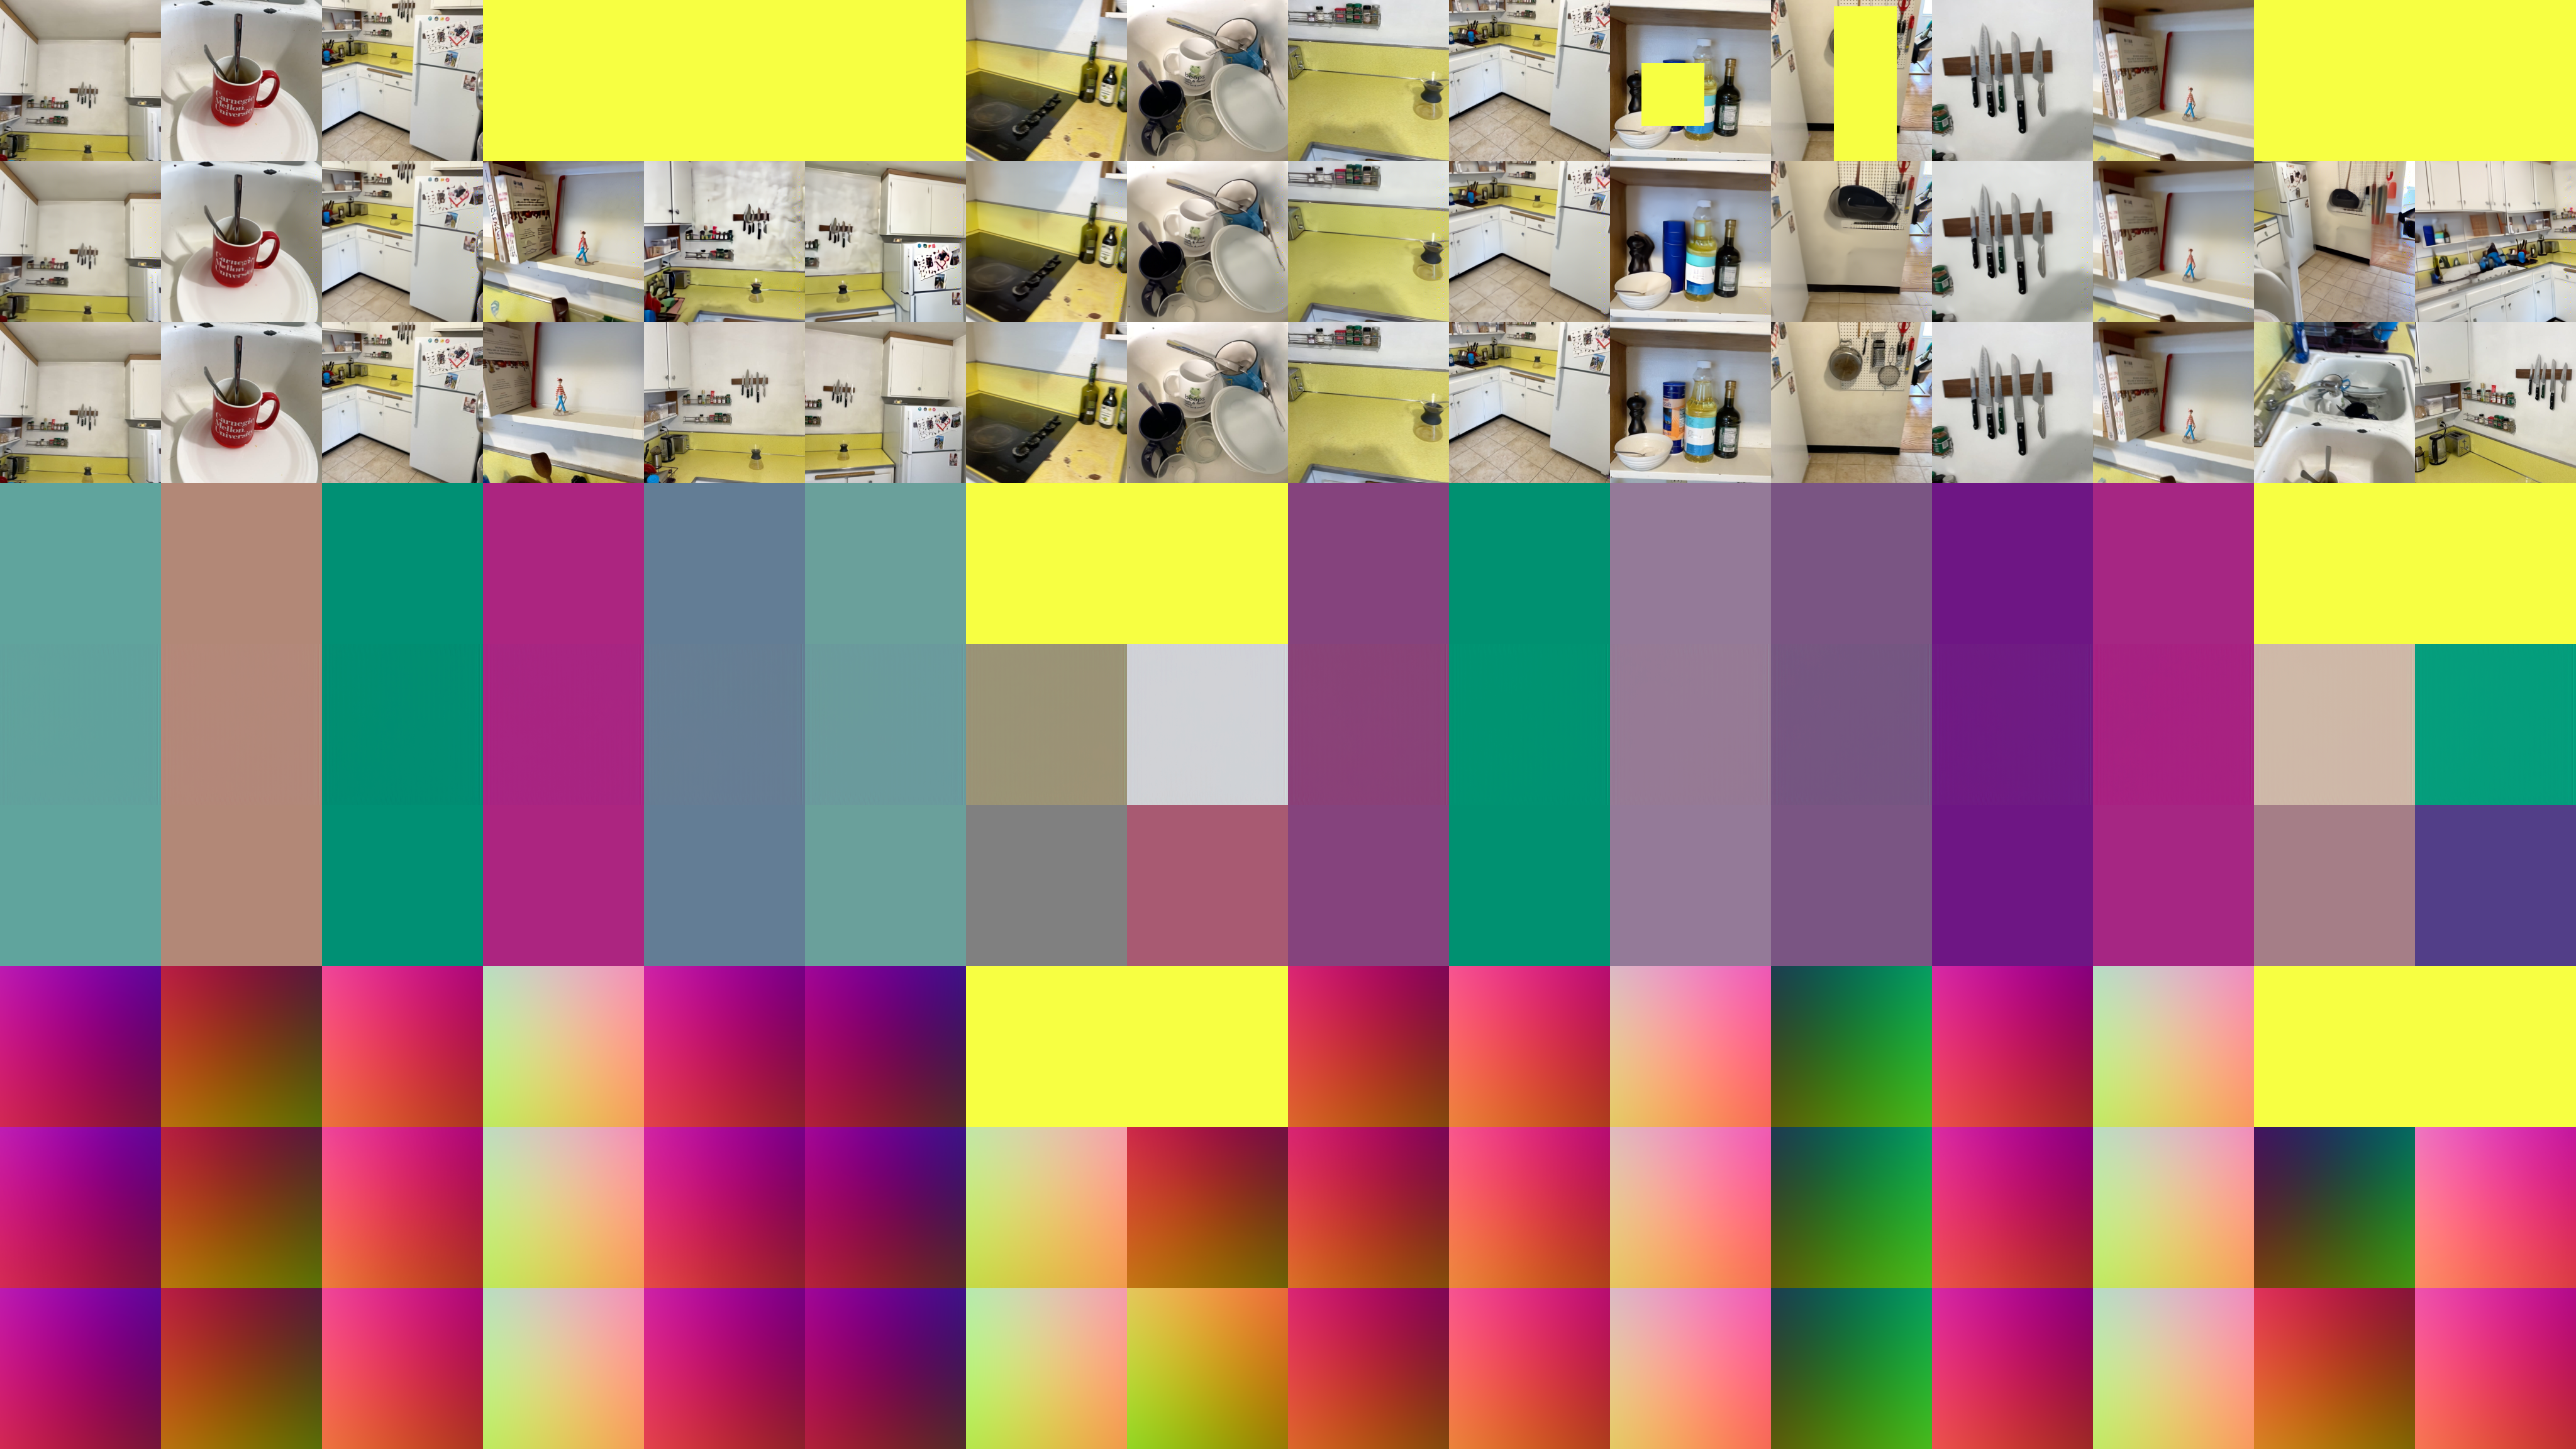

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.

In [36]:
# _ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras", resize=True)
_ = draw_cameras(viser_server, cameras=cameras[0], datas=None, prefix="cameras", resize=True)

before = time.time()
image_pred, origins_pred, directions_pred = nerfstudio_pipeline.inpainter.inpainter.sample(
    image=image,
    origins=origins,
    directions=directions,
    image_mask=image_mask,
    rays_mask=rays_mask,
    text=text,
    uncond_text=uncond_text,
    current_image=image,
    image_strength=image_strength,
    num_test_timesteps=num_test_timesteps,
    cfg_mv=cfg_mv,
    cfg_mv_known=cfg_mv_known,
    cfg_te=cfg_te,
    camera_to_worlds=cameras.camera_to_worlds,
)
after = time.time()
print(f"Time to sample (sec): {after - before}")

if show_summary:
    # SUMMARY IMAGES
    summary_image_list = get_summary_image_list(image_pred, image,
                                            origins_pred / 2.0 + 0.5, origins / 2.0 + 0.5, directions_pred / 2.0 + 0.5, directions / 2.0 + 0.5,
                                            image_mask, rays_mask)
    mediapy.show_images(summary_image_list, columns=b, height=summary_image_height)
    for i in range(len(summary_image_list)):
        mediapy.write_image(f"samples/sample-{i}.png", summary_image_list[0])
    
    # SUMMARY VIDEOS
    summary_videos = [summary_image.split(w, dim=1) for summary_image in summary_image_list]
    videos = [[frame.numpy()[h:h*2] if summary_video_show_top_only else frame.numpy() for frame in video] for video in summary_videos]
    video_length = len(videos[0][summary_video_start_index:])
    mediapy.show_videos([video[summary_video_start_index:] for video in videos], columns=b, width=w, fps=video_length/summary_video_seconds)
    # filename = flexible_folder / "video.mp4"
    # mediapy.write_video(filename, [video[summary_video_start_index:] for video in videos][0], fps=video_length/summary_video_seconds)
    for i in range(len(videos)):
        mediapy.write_video(f"samples/samples-{i}.mp4", videos[i][summary_video_start_index:], fps=video_length/summary_video_seconds)
    if show_flattened_video:
        flattened_video = np.concatenate(videos, axis=2)
        mediapy.show_video(flattened_video[summary_video_start_index:], fps=video_length/summary_video_seconds)
        filename = flexible_folder / "video.mp4"
        mediapy.write_image(filename, flattened_video[summary_video_start_index:], fps=video_length/summary_video_seconds)

In [416]:
# image.shape

In [417]:
# cameras_pred = fit_cameras(origins_pred[0], directions_pred[0], niters=700)
# cameras_pred.rescale_output_resolution(1 / scale_factor)
# cameras_pred = cameras_pred.reshape((1, origins_pred[0].shape[0]))
# cameras = cameras_pred
# _ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image_pred[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras-final", resize=True)

# Save as Nerfstudio Dataset

In [299]:
# num_patches

In [11]:
from fillerbuster.utils.nerfstudio_dataset_utils import create_nerfstudio_frame
import json
import shutil

# output_folder = Path("/mnt/captures/spaces/datasets/uncalibrated-scene-reconstruction/office-big")
output_folder = Path("/mnt/captures/spaces/datasets/improving-viewcrafter/temp")
output_folder.mkdir(parents=True, exist_ok=True)
if (output_folder / "images").exists():
    shutil.rmtree(output_folder / "images")
(output_folder / "images").mkdir(parents=True, exist_ok=True)

template = {
    "camera_model": "OPENCV",
    "orientation_override": "none",
    "frames": [],
}
frames = []
for i in range(len(cameras[0])):
    # if i >= num_patches:
    #     break

    pose = torch.cat([cameras[0][i].camera_to_worlds, torch.zeros_like(cameras[0][i].camera_to_worlds[:1])], dim=0)
    pose[-1,-1] = 1
    # pose = torch.eye(4)
    # pose[:3,3] = torch.rand(3) * 2 - 1
    
    file_path = f"images/image_{i:06d}.png"
    # if i >= num_patches:
    #     mediapy.write_image(output_folder / file_path, image_pred[0][i].permute(1,2,0).cpu()) # or predicted images?
    # else:
    #     mediapy.write_image(output_folder / file_path, image[0][i].permute(1,2,0).cpu()) # or predicted images?

    # all predicted images
    mediapy.write_image(output_folder / file_path, image_pred[0][i].permute(1,2,0).cpu())
    # mediapy.write_image(output_folder / file_path, image[0][i].permute(1,2,0).cpu())

    frame = create_nerfstudio_frame(
        fl_x=cameras[0][i].fx.item(),
        fl_y=cameras[0][i].fy.item(),
        cx=cameras[0][i].cx.item(),
        cy=cameras[0][i].cy.item(),
        w=cameras[0][i].width.item(),
        h=cameras[0][i].height.item(),
        pose=pose,
        file_path=file_path,
    )
    frames.append(frame)
template["frames"] = frames
with open(output_folder / "transforms.json", "w") as f:
    json.dump(template, f, indent=4)

NameError: name 'cameras' is not defined

In [74]:
for i in range(image.shape[1]):
    if i >= 16:
        break
    # mediapy.show_image(image[0,i].permute(1,2,0).detach().cpu())
    mediapy.write_image(f"statue/image_{i:06d}.png", image[0,i].permute(1,2,0).detach().cpu())
    # break

In [63]:
# conditoning_indices = torch.tensor(random.sample(nerfstudio_pipeline.conditoning_indices, min(nerfstudio_pipeline.config.context_size, len(nerfstudio_pipeline.conditoning_indices))))
# image, image_mask, origins, directions, rays_mask, cameras, original_image_mask = nerfstudio_pipeline.get_input(conditoning_indices, size=(256, 256), radius_mean=1.0)

# 3D Visualization

In [54]:
viser_server.add_box(name="box", color=(255,0,0), dimensions=(2,2,2), position=(0,0,0), visible=False)
draw_multi_view_batch(viser_server, image_pred, origins_pred, directions_pred, name="batch-pred")
draw_multi_view_batch(viser_server, image, origins, directions, name="batch")

# Test Ray Augmentation

In [371]:
origins_aug, directions_aug, _, _, _ = augment_origins_and_direction(origins, directions, cameras.camera_to_worlds)
draw_multi_view_batch(viser_server, image, origins_aug, directions_aug, name="augmented")